# Data-X Spring 2019: Homework 9

## Student name: Ran Meng






## Student id: 3034368718

## Github: https://github.com/ranmeng747/rmeng4_data_x_s19

**Q1.** You have now seen how Neural networks work. You have also seen how to create and visualize neural networks using Tensorflow and Tensorboard. In this Question, you will be working on Neural networks. You will be using MNIST data (labelled images of digits) that we discussed in the class to create vanilla dense Neural network model using **tensorflow** (version 2.x is preferred, you can use 1.x as well,  **Limit the use of Keras** for solving this question) with the following characteristics:
- Input layer size of 784 (Since each image is 28 * 28)
- Three hidden layers of 300, 200 , 100
- Output layer of 10 (Since 0 - 9 digits)
- Use stochastic gradient descent
- Any other requirements can be your choice

Note that you have to define own functions for calculating loss function, optimizer to feed into the neural network.
**Plot your neural network graph (using tensorboard) and the plot of performance results (Training and Validation accuracies and loss) for every epoch**

Note: You can access MNIST data from **keras.datasets** [Link](https://keras.io/datasets/#mnist-database-of-handwritten-digits) or any standard available MNIST datasource (http://yann.lecun.com/exdb/mnist/) 

In [120]:
# Your code hereimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
import cv2

In [2]:
tf.__version__

'1.12.0'

In [121]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [122]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [123]:
tf.reset_default_graph()

In [124]:
# Define hyperparameters and input size

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [125]:
# Define neuron layers (ReLU in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z


In [126]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                       activation = tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                       activation = tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                       activation = tf.nn.relu)

    logits = neuron_layer(hidden3, n_outputs, name="outputs")

In [127]:
# Define loss function
with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
#tf.summary.scalar('loss', loss)

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) #Stochastic Gradient Descent
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1) 
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
#tf.summary.scalar('accuracy', accuracy)

In [128]:
from tensorflow.examples.tutorials.mnist import input_data

# new folder
mnist = input_data.read_data_sets("/tmp/data/")

# Assign them to values
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

print('Train input shape:',X_train.shape)
print('Test input shape:',X_test.shape)
print('Train output shape:', y_train.shape)
print('Input data type:',X_train.dtype)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Train input shape: (55000, 784)
Test input shape: (10000, 784)
Train output shape: (55000,)
Input data type: float32


### Train Steps

In [129]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 15
batch_size = 50
acc_train_lst = []
loss_train_lst = []
acc_val_lst = []
loss_val_lst = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        
        
        acc_train_lst.append(acc_train)
        loss_train_lst.append(loss_train)
        acc_val_lst.append(acc_val)
        loss_val_lst.append(loss_val)
        print(epoch, "Train accuracy:", acc_train, "Train loss: ", loss_train, "Val accuracy:", acc_val, "Val loss: ", loss_val)

    save_path = saver.save(sess, "../my_model_final.ckpt") # save model

0 Train accuracy: 0.96 Train loss:  0.28319654 Val accuracy: 0.926 Val loss:  0.25564626
1 Train accuracy: 1.0 Train loss:  0.054517 Val accuracy: 0.9436 Val loss:  0.20603028
2 Train accuracy: 0.98 Train loss:  0.1428445 Val accuracy: 0.9542 Val loss:  0.16656409
3 Train accuracy: 0.96 Train loss:  0.1689844 Val accuracy: 0.9566 Val loss:  0.14770462
4 Train accuracy: 1.0 Train loss:  0.044283543 Val accuracy: 0.9632 Val loss:  0.13188615
5 Train accuracy: 0.96 Train loss:  0.095299624 Val accuracy: 0.9634 Val loss:  0.12588441
6 Train accuracy: 1.0 Train loss:  0.017045373 Val accuracy: 0.9674 Val loss:  0.116386645
7 Train accuracy: 0.96 Train loss:  0.13456993 Val accuracy: 0.969 Val loss:  0.1104155
8 Train accuracy: 0.98 Train loss:  0.09671759 Val accuracy: 0.9702 Val loss:  0.10179249
9 Train accuracy: 1.0 Train loss:  0.016730972 Val accuracy: 0.9726 Val loss:  0.096912
10 Train accuracy: 1.0 Train loss:  0.014002158 Val accuracy: 0.9714 Val loss:  0.095892765
11 Train accurac

In [130]:
show_graph(tf.get_default_graph())

Text(0.5, 1.0, 'Training accuracy')

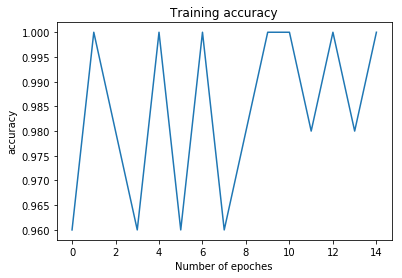

In [131]:
# plot training accuracy
plt.plot(range(n_epochs), acc_train_lst)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Training accuracy')

Text(0.5, 1.0, 'Validation accuracy')

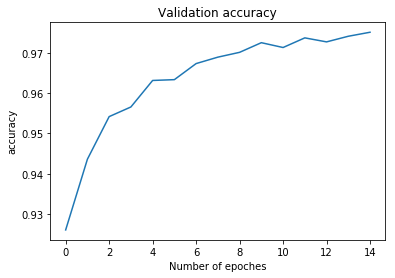

In [135]:
# plot validation accuracy
plt.plot(range(n_epochs),acc_val_lst)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Validation accuracy')

Text(0.5, 1.0, 'Training loss')

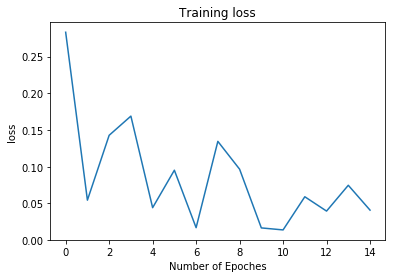

In [133]:
# plot training loss
plt.plot(range(n_epochs), loss_train_lst)
plt.xlabel('Number of Epoches')
plt.ylabel('loss')
plt.title('Training loss')

Text(0.5, 1.0, 'validation loss')

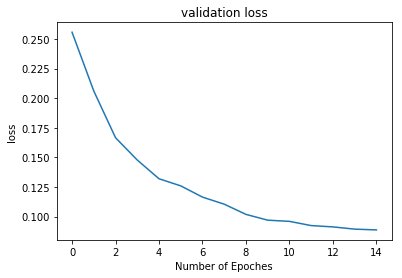

In [134]:
# plot validation loss
plt.plot(range(n_epochs),loss_val_lst)
plt.xlabel('Number of Epoches')
plt.ylabel('loss')
plt.title('validation loss')

**Q2.** Use transfer learning and use the Imagenet VGG16 model to train on MNIST data. You can use **Keras** for solving this question. You can choose any requirements on loss function, optimizer etc. **Plot the performance results (Training and Validation accuracies & loss) for every epoch**

In [78]:
# load dataset
(x_train, y_train), (x_test, y_test) = tf.keras. \
                            datasets.mnist.load_data()



# First reshape to add channel information
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1). \
                    astype('float32') / 255

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1). \
                    astype('float32') / 255

print('Train input shape:',x_train.shape)
print('Train input type:', type(x_train))
print('Test input shape:',x_test.shape)

print('Train output shape:',y_train.shape)
print('Test output shape:',y_test.shape)
print('Data type:',y_train.dtype)

Train input shape: (60000, 28, 28, 1)
Train input type: <class 'numpy.ndarray'>
Test input shape: (10000, 28, 28, 1)
Train output shape: (60000,)
Test output shape: (10000,)
Data type: uint8


Convert to RGB and resize:

In [79]:
x_train_lst = []

for img in x_train:
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    reshaped = cv2.resize(rgb, (42,42))
    x_train_lst.append(reshaped)

In [80]:
x_test_lst = []

for img in x_test:
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    reshaped = cv2.resize(rgb, (42,42))
    x_test_lst.append(reshaped)

In [100]:
x_train_input = np.array(x_train_lst)
x_test_input = np.array(x_test_lst)

y_train_input = keras.utils.to_categorical(y_train, 10)
y_test_input = keras.utils.to_categorical(y_test, 10)

In [104]:
print(x_train_input.shape)
print(y_train_input.shape)

(60000, 42, 42, 3)
(60000, 10)


#### Using VGG16 base model, append with other layers and extract features by using Keras

In [32]:
from tensorflow.keras import applications
model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                    input_tensor=None, input_shape=(42, 42, 3))

In [105]:
train_features = model.predict(x_train_input, batch_size = 16, verbose=1)
test_features = model.predict(x_test_input, batch_size=16, verbose=1)

10000/10000 [==============================] - 274s 27ms/step


In [106]:
np.savez("train_features", train_features, y_train_input)
np.savez("test_features", test_features, y_test_input)

In [107]:
print(train_features.shape)
print(test_features.shape)

(60000, 1, 1, 512)
(10000, 1, 1, 512)


In [109]:
train_features_flat = np.reshape(train_features, (60000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))

print(train_features_flat.shape)
print(test_features_flat.shape)

(60000, 512)
(10000, 512)


In [112]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, LeakyReLU
from time import time

mod = Sequential()
mod.add(layers.Dense(512, activation=tf.nn.relu, input_dim=(1*1*512)))
mod.add(layers.LeakyReLU(alpha=0.1))
mod.add(layers.Dense(10, activation=tf.nn.softmax))

In [113]:
mod.compile(optimizer='adam', #Using Adam Optimizer
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = mod.fit(x = train_features_flat, y = y_train, validation_split= 0.1, epochs = 20)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 17s 319us/step - loss: 0.2869 - acc: 0.9171 - val_loss: 0.1418 - val_acc: 0.9550
Epoch 2/20
54000/54000 [==============================] - 16s 297us/step - loss: 0.1318 - acc: 0.9595 - val_loss: 0.1207 - val_acc: 0.9595
Epoch 3/20
54000/54000 [==============================] - 17s 307us/step - loss: 0.1095 - acc: 0.9648 - val_loss: 0.0872 - val_acc: 0.9723
Epoch 4/20
54000/54000 [==============================] - 16s 304us/step - loss: 0.0970 - acc: 0.9686 - val_loss: 0.0710 - val_acc: 0.9778
Epoch 5/20
54000/54000 [==============================] - 17s 306us/step - loss: 0.0877 - acc: 0.9716 - val_loss: 0.0819 - val_acc: 0.9733
Epoch 6/20
54000/54000 [==============================] - 17s 309us/step - loss: 0.0792 - acc: 0.9735 - val_loss: 0.1185 - val_acc: 0.9637
Epoch 7/20
54000/54000 [==============================] - 17s 322us/step - loss: 0.0746 - acc: 0.9755 - val_loss: 0.0

In [114]:
vgg16_performance = mod.evaluate(test_features_flat, y_test)
vgg16_performance

10000/10000 [==============================] - 1s 69us/step


[0.08108601624090224, 0.9754]

In [115]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

Text(0.5, 1.0, 'Training accuracy')

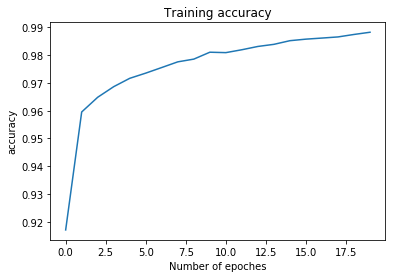

In [116]:
plt.plot(epochs, acc)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Training accuracy')

Text(0.5, 1.0, 'Validation accuracy')

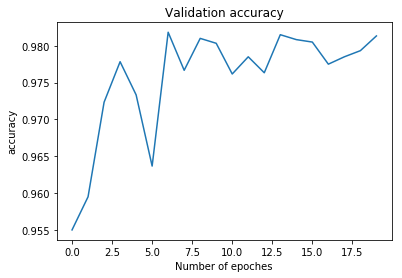

In [117]:
plt.plot(epochs, val_acc)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Validation accuracy')

Text(0.5, 1.0, 'Training loss')

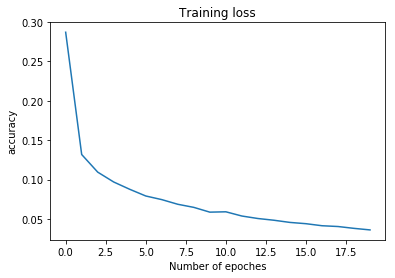

In [118]:
plt.plot(epochs, loss)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Training loss')

Text(0.5, 1.0, 'Validation loss')

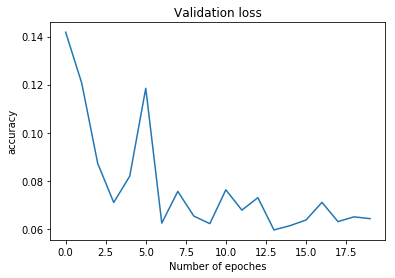

In [119]:
plt.plot(epochs, val_loss)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Validation loss')

**EXTRA CREDIT Q.** **(MANDATORY for students taking IND ENG 290)** Customize your neural networks in **Q1** to how many ever layers you want, use [batch normalization](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization) and [Adam Optimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) and try different regularization techniques to combat overfitting. Also use as many iterations you want and plot every 10th iteration on the tensorboard. We will give extra credit if you achieve more than **98.5%** on the MNIST data. **Plot the neural network graph (using tensorboard) and describe the settings that you used and the performance results. Also plot performance results (Training and Validation accuracies & loss) for every epoch**

Note: You can use Keras if necessary for solving this question

If you cannot run your tensorflow notebooks locally, you can use. 
https://datahub.berkeley.edu/hub/home

###  Using Keras

In [65]:
(x_train, y_train), (x_test, y_test) = tf.keras. \
                            datasets.mnist.load_data()

x_train_reshaped = x_train.reshape(x_train.shape[0], 28, 28, 1). \
                    astype('float32') / 255

x_test_reshaped = x_test.reshape(x_test.shape[0], 28, 28, 1) \
                    .astype('float32') / 255

print(x_train_reshaped.shape)
print(y_train.shape)
print(x_test_reshaped.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [68]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, LeakyReLU
from time import time

# Creating a Sequential Model and adding the layers
mod2 = Sequential()
mod2.add(Conv2D(28, kernel_size=(3,3), input_shape=(28, 28, 1))) #CNN network 
mod2.add(LeakyReLU(alpha=0.1))
#mod2.add(Dropout(0.2))

mod2.add(MaxPooling2D(pool_size=(2, 2)))
mod2.add(Flatten()) # Flattening the 2D arrays for fully connected layers

mod2.add(BatchNormalization())# Apply batch normalization
mod2.add(Dense(128, activation=tf.nn.relu))
mod2.add(LeakyReLU(alpha=0.1))
mod2.add(Dropout(0.1))

mod2.add(BatchNormalization())# Apply batch normalization
mod2.add(Dense(10,activation=tf.nn.softmax))

In [69]:
mod2.compile(optimizer='adam', #Using Adam Optimizer
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = mod2.fit(x = x_train_reshaped,y = y_train, validation_split= 0.1, epochs = 5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 83s 2ms/step - loss: 0.1369 - acc: 0.9584 - val_loss: 0.0563 - val_acc: 0.9838
Epoch 2/5
54000/54000 [==============================] - 89s 2ms/step - loss: 0.0575 - acc: 0.9817 - val_loss: 0.0436 - val_acc: 0.9878
Epoch 3/5
54000/54000 [==============================] - 81s 2ms/step - loss: 0.0393 - acc: 0.9874 - val_loss: 0.0543 - val_acc: 0.9848
Epoch 4/5
54000/54000 [==============================] - 82s 2ms/step - loss: 0.0294 - acc: 0.9902 - val_loss: 0.0482 - val_acc: 0.9870
Epoch 5/5
54000/54000 [==============================] - 79s 1ms/step - loss: 0.0254 - acc: 0.9917 - val_loss: 0.0469 - val_acc: 0.9893


I am using Keras and I get confirmation from the GSIs during office hours that no tensorboard display is necessary if we are modelling with Keras, so I hope this visiualization is sufficient

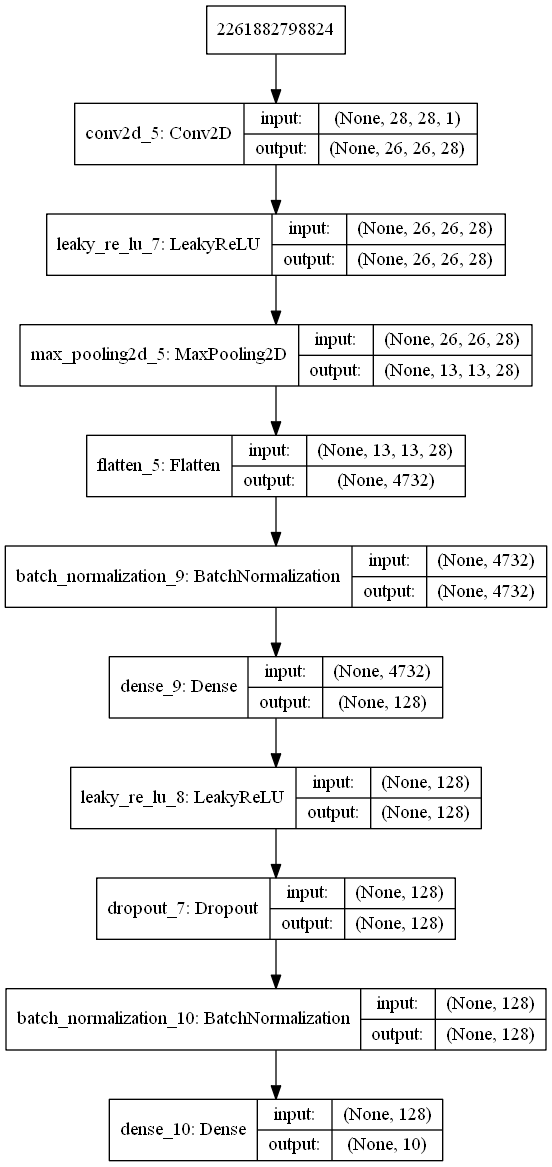

In [70]:
from keras.utils.vis_utils import plot_model
import IPython
plot_model(mod2, to_file = 'mod2.png', show_shapes = True, show_layer_names = True)
IPython.display.Image('mod2.png')

In [71]:
test_performance = mod2.evaluate(x_test_reshaped, y_test)
test_performance

10000/10000 [==============================] - 4s 365us/step


[0.048045207807555564, 0.9851]

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

Text(0.5, 1.0, 'Training accuracy')

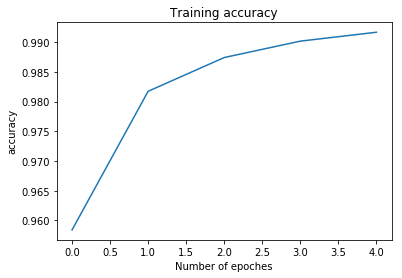

In [73]:
plt.plot(epochs, acc)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Training accuracy')

Text(0.5, 1.0, 'Validation accuracy')

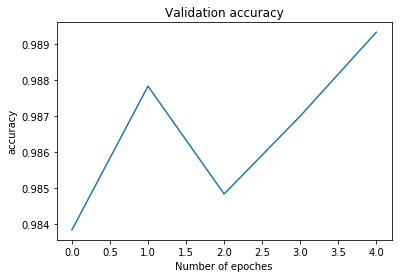

In [74]:
plt.plot(epochs, val_acc)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Validation accuracy')

Text(0.5, 1.0, 'Training loss')

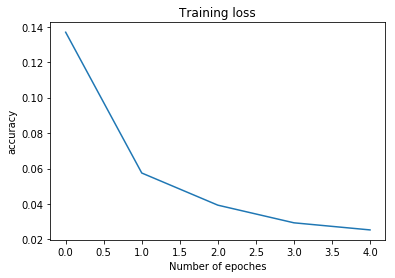

In [75]:
plt.plot(epochs, loss)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Training loss')

Text(0.5, 1.0, 'Validation loss')

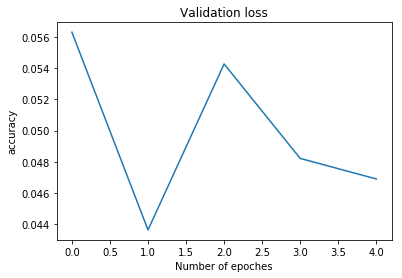

In [76]:
plt.plot(epochs, val_loss)
plt.xlabel('Number of epoches')
plt.ylabel('accuracy')
plt.title('Validation loss')

In [77]:
print('Final testing accuracy greater than 98.5%: ', test_performance[1]*100, '%')

Final testing accuracy greater than 98.5%:  98.50999999999999 %
